In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%load_ext lab_black

import sys

sys.path.append("..")
from src.data import make_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as sm
import ppscore as pps
import scipy

# How efficient are gas fired power stations?

To understand efficiency of gas fired power stations, we must first define what efficiency is. We're defining efficiency in the context of energy conversion, which simplifies the system to mean that efficiency is the total energy in, divided by the total energy out.

To calculate this, we convert the total daily UK gas energy (using demand volume and calorific values for powerstations) to GWH/day.

Electricity data is given as average MW values per 30 minute settlement period, we convert this to a total GWH/day.

[https://en.wikipedia.org/wiki/Energy_conversion_efficiency]

In [2]:
elec = make_dataset.prepare_electricity_actuals(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\ELECTRICITY_ACTUALS.csv"
)
daily_elec_averages = elec[["CCGT", "OCGT"]].fillna(0).sum(axis=1)
daily_elec_GWH = daily_elec_averages * 24 / 1000

Electricity generation shows clear seasonality, which we explored partially in [1]. This is due to seasonally increased electricity demand, as well as fluctuations in wind and other generation components.

In [3]:
def plot_series(series):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    sns.histplot(series, kde=True, ax=ax[0])
    ax[0].set_title(f"{series.name} Histogram")

    ax[1].plot(series)
    ax[1].set_title(f"{series.name} Over Time")
    plt.show()

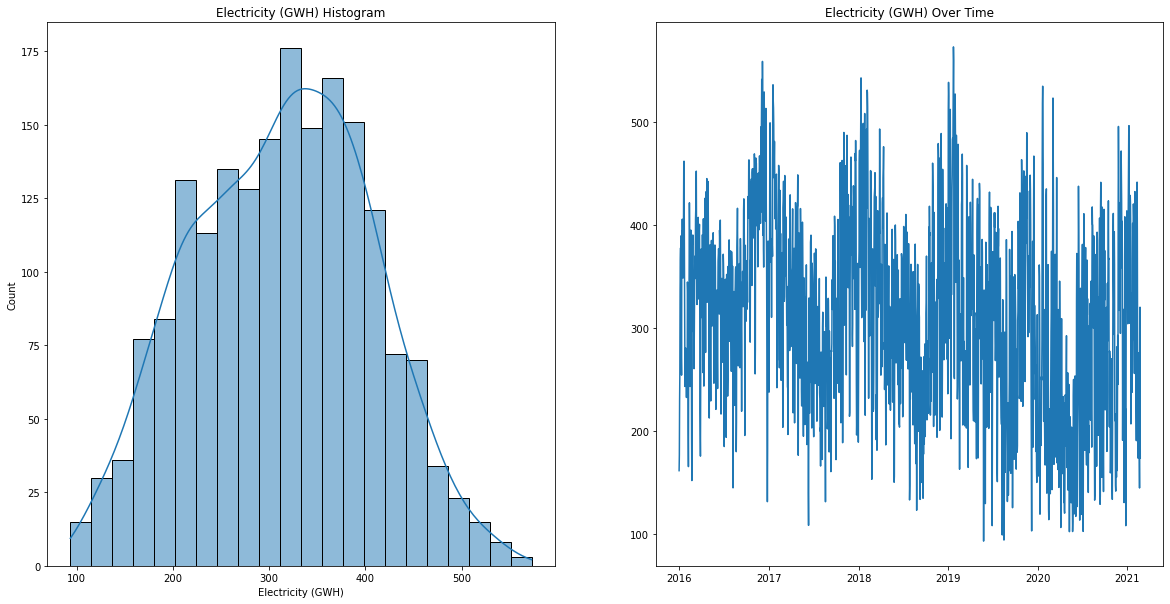

In [4]:
plot_series(daily_elec_GWH.rename("Electricity (GWH)"))

The energy provided by gas is derived from two primary attributes, its' volume and calorifiv value (CV). Volume is measured in MCM (million cubic meters) and refers to the quantity of gas in question. The CV is dependent on the gas content, and refers to the amount of energy released by the gas when a fixed volume is combusted.  [The CV of gas, which is dry, gross and measured at standard conditions of temperature (15oC) and pressure (1013.25 millibars), is usually quoted in megajoules per cubic metre (MJ/m3). Gas passing through our pipeline system has a CV of 37.5 MJ/m3 to 43.0 MJ/m3.]

This means to calculate the energy used we can start by multiplying the volume by the calorific value.

In [42]:
gas_energy = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_ENERGY.csv"
).rename({"VALUE": "ENERGY"}, axis=1)
# kWH

gas_energy = make_dataset.map_to_sites(gas_energy)

# clean up the data types
gas_energy["ENERGY"] = (
    gas_energy["ENERGY"].str.replace(",", "").astype(float)
)  # some rogue string characters in there
gas_energy["ENERGY_GWH"] = gas_energy["ENERGY"] / 1000000

C:\Users\rachel.hassall\.conda\envs\charterful\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
# calculate the daily average energy for all Powerstations
daily_gas_energy = gas_energy.groupby("GAS_DAY")["ENERGY_GWH"].sum().tz_localize(None)

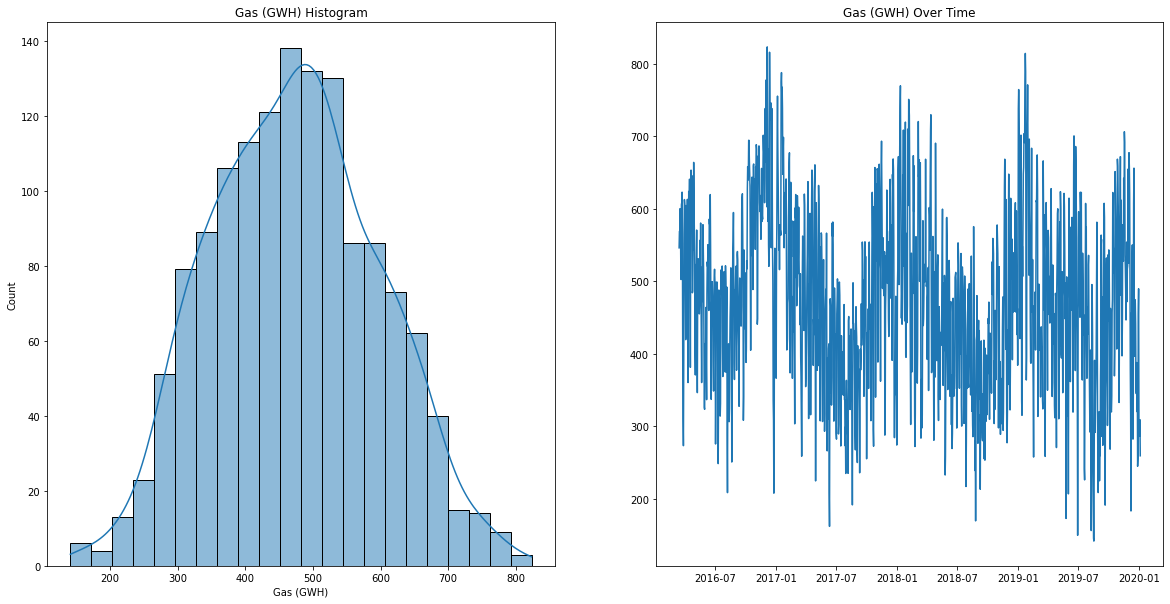

In [35]:
plot_series(daily_gas_energy.rename("Gas (GWH)"))

In [36]:
df = pd.DataFrame({"ELECTRICITY": daily_elec_GWH, "GAS": daily_gas_energy}).dropna()
df["EFFICIENCY"] = df["ELECTRICITY"] / df["GAS"]
df["EFFICIENCY"].describe()

count    1393.000000
mean        0.687192
std         0.052073
min         0.527030
25%         0.657998
50%         0.688107
75%         0.715965
max         0.895248
Name: EFFICIENCY, dtype: float64

Powerstations have a mean efficiency of 55%, peaking at 68% and troughing at 44%. 

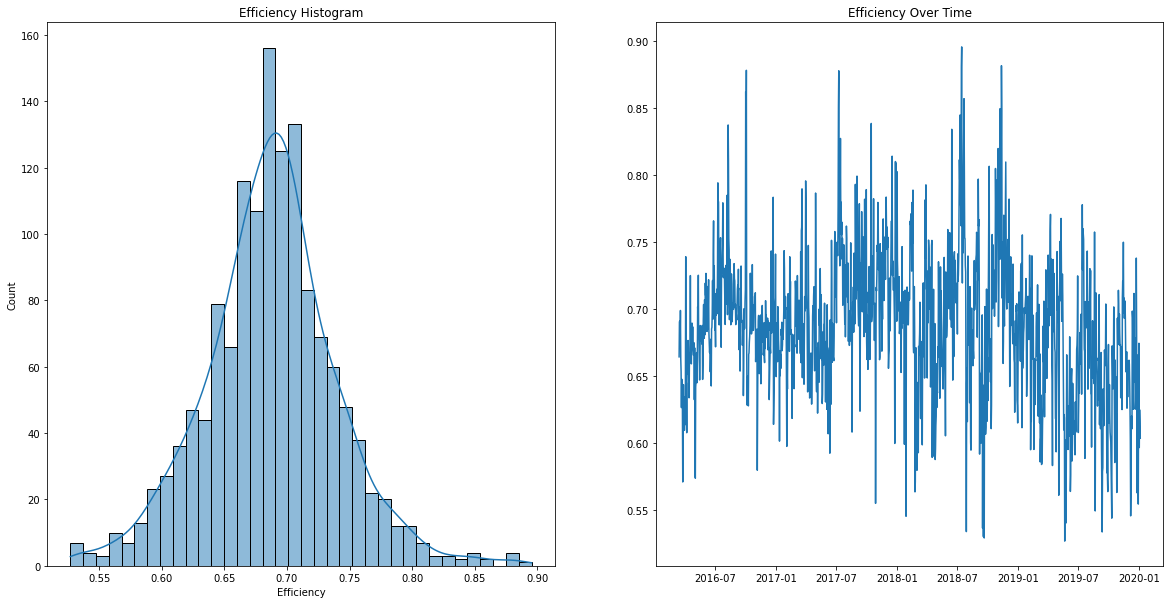

In [37]:
plot_series(df["EFFICIENCY"].rename("Efficiency"))

## Does Efficiency change seasonally?

In time series analysis, "seasonally" is used generically to mean patterns in data with a certain period. For example we can have yearly seasonality (winter effects) with a period of 365 days, as well as monthly seasonality (month end) with a period of 30 days and weekly seasonality (weekend effects) with a period of 7 days.

We can begin to decompose any seasonal affects by doing autocorrelation analysis and comparing each value with a lagged version of itself i.e. compare today's value with the value from a year ago.

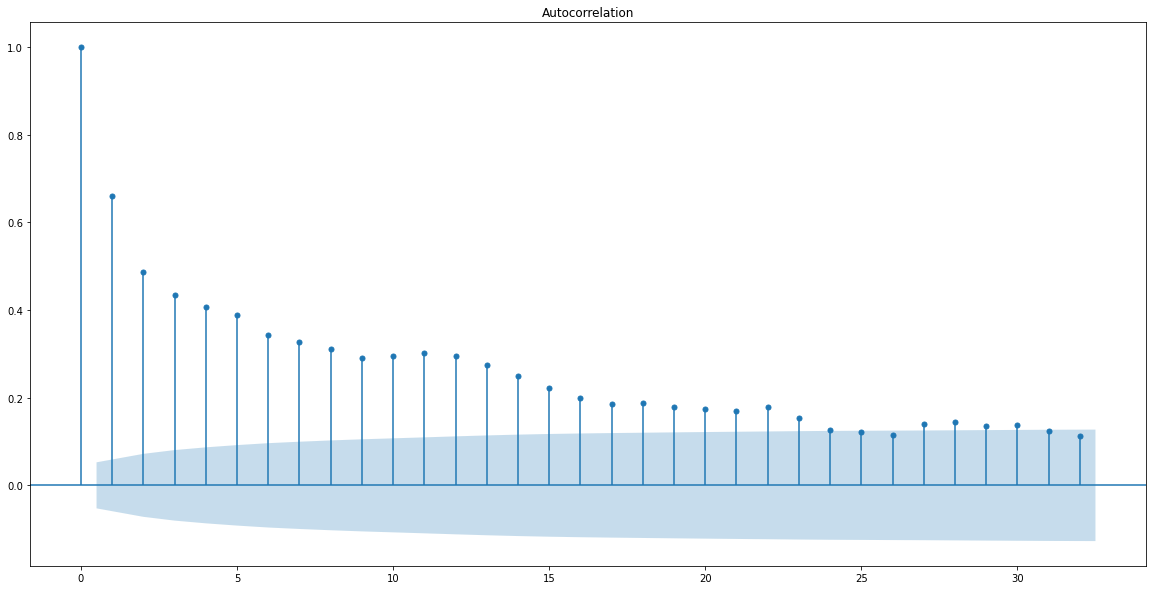

In [38]:
from statsmodels.graphics import tsaplots

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

lags = None

a = tsaplots.plot_acf(df["EFFICIENCY"], lags=lags, ax=ax)

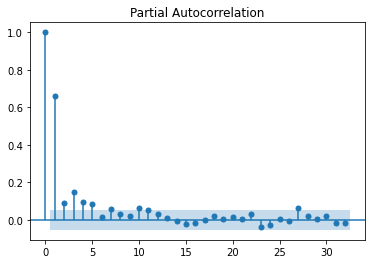

In [11]:
b = tsaplots.plot_pacf(df["EFFICIENCY"], lags=lags)

A more complex method is to build an additive model to understand various seasonal components, the facebook prophet library does this very well so let's have a look.

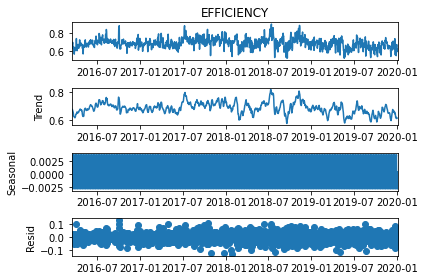

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonality = seasonal_decompose(df["EFFICIENCY"], model="additive")

a = seasonality.plot()

In [ ]:
from prophet import Prophet

proph_data = df["EFFICIENCY"].reset_index()
proph_data = proph_data.rename({"GAS_DAY" : "ds", "EFFICIENCY" : "y"}, axis=1)

m = Prophet()
m.fit()

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)


fig2 = m.plot_components(forecast)


# Does Energy = Volume * CV?

- Calorific value is in MJ/scm
- Energy is in kWh
- Volume is in mscm

In [40]:
gas_volume = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_VOLUME.csv"
).rename({"VALUE": "VOLUME"}, axis=1)
# kWH

gas_volume = make_dataset.map_to_sites(gas_volume)
gas_volume.head()

,ITEM,GAS_DAY,VOLUME,SITE
17,"NTS PHYSICAL FLOWS, BAGLANBAY, NTS POWER STATION",2016-03-14,1.72800,BAGLANBAY
23,"NTS PHYSICAL FLOWS, BLACKBRIDGE, NTS POWER STA...",2016-03-14,8.12001,BLACKBRIDGE
33,"NTS PHYSICAL FLOWS, BRIGG, NTS POWER STATION",2016-03-14,0.00000,BRIGG
38,"NTS PHYSICAL FLOWS, BURTONPOINT, NTS POWER STA...",2016-03-14,0.40800,BURTONPOINT
48,"NTS PHYSICAL FLOWS, CORBY, NTS POWER STATION",2016-03-14,0.00000,CORBY


In [41]:
gas_cv = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_CV.csv"
).rename({"VALUE": "CV"}, axis=1)
# kWH

gas_cv = make_dataset.map_to_sites(gas_cv)
# MJ/scm
gas_cv.head()

,ITEM,GAS_DAY,CV,SITE
17,"CALORIFIC VALUE, BAGLANBAY, NTS POWER STATION",2016-03-14,39.21,BAGLANBAY
23,"CALORIFIC VALUE, BLACKBRIDGE, NTS POWER STATION",2016-03-14,39.15,BLACKBRIDGE
33,"CALORIFIC VALUE, BRIGG, NTS POWER STATION",2016-03-14,39.74,BRIGG
38,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2016-03-14,39.78,BURTONPOINT
49,"CALORIFIC VALUE, CORBY, NTS POWER STATION",2016-03-14,39.19,CORBY


In [16]:
gas_cv[gas_cv["SITE"] == "BURTONPOINT"]

,ITEM,GAS_DAY,CV,SITE
38,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2016-03-14 00:00:00+00:00,39.78,BURTONPOINT
365,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2016-03-15 00:00:00+00:00,40.72,BURTONPOINT
693,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2016-03-16 00:00:00+00:00,41.07,BURTONPOINT
1021,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2016-03-17 00:00:00+00:00,40.09,BURTONPOINT
1349,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2016-03-18 00:00:00+00:00,39.56,BURTONPOINT
...,...,...,...,...
449662,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2020-01-01 00:00:00+00:00,42.03,BURTONPOINT
449948,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2020-01-02 00:00:00+00:00,41.87,BURTONPOINT
450266,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2020-01-03 00:00:00+00:00,40.40,BURTONPOINT
450584,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",2020-01-04 00:00:00+00:00,42.18,BURTONPOINT


In [44]:
compare = gas_volume.merge(
    gas_cv, left_on=["GAS_DAY", "SITE"], right_on=["GAS_DAY", "SITE"]
)
compare = compare.merge(
    gas_energy, left_on=["GAS_DAY", "SITE"], right_on=["GAS_DAY", "SITE"]
)
compare

,ITEM_x,GAS_DAY,VOLUME,SITE,ITEM_y,CV,ITEM,ENERGY,ENERGY_GWH
0,"NTS PHYSICAL FLOWS, BAGLANBAY, NTS POWER STATION",2016-03-14,1.72800,BAGLANBAY,"CALORIFIC VALUE, BAGLANBAY, NTS POWER STATION",39.21,"NTS ENERGY OFFTAKEN, BAGLANBAY, NTS POWER STATION",18816562.0,18.816562
1,"NTS PHYSICAL FLOWS, BLACKBRIDGE, NTS POWER STA...",2016-03-14,8.12001,BLACKBRIDGE,"CALORIFIC VALUE, BLACKBRIDGE, NTS POWER STATION",39.15,"NTS ENERGY OFFTAKEN, BLACKBRIDGE, NTS POWER ST...",88322211.0,88.322211
2,"NTS PHYSICAL FLOWS, BRIGG, NTS POWER STATION",2016-03-14,0.00000,BRIGG,"CALORIFIC VALUE, BRIGG, NTS POWER STATION",39.74,"NTS ENERGY OFFTAKEN, BRIGG, NTS POWER STATION",0.0,0.000000
3,"NTS PHYSICAL FLOWS, BURTONPOINT, NTS POWER STA...",2016-03-14,0.40800,BURTONPOINT,"CALORIFIC VALUE, BURTONPOINT, NTS POWER STATION",39.78,"NTS ENERGY OFFTAKEN, BURTONPOINT, NTS POWER ST...",4504462.0,4.504462
4,"NTS PHYSICAL FLOWS, CORBY, NTS POWER STATION",2016-03-14,0.00000,CORBY,"CALORIFIC VALUE, CORBY, NTS POWER STATION",39.19,"NTS ENERGY OFFTAKEN, CORBY, NTS POWER STATION",0.0,0.000000
...,...,...,...,...,...,...,...,...,...
52333,"NTS PHYSICAL FLOWS, STAYTHORPE, NTS POWER STATION",2020-01-05,1.32000,STAYTHORPE,"CALORIFIC VALUE, STAYTHORPE, NTS POWER STATION",39.45,"NTS ENERGY OFFTAKEN, STAYTHORPE, NTS POWER STA...",14455556.0,14.455556
52334,"NTS PHYSICAL FLOWS, SUTTONBRIDGE, NTS POWER ST...",2020-01-05,0.21300,SUTTONBRIDGE,"CALORIFIC VALUE, SUTTONBRIDGE, NTS POWER STATION",39.33,"NTS ENERGY OFFTAKEN, SUTTONBRIDGE, NTS POWER S...",2327778.0,2.327778
52335,"NTS PHYSICAL FLOWS, TEESSIDE NSMP, NTS POWER S...",2020-01-05,0.01398,TEESSIDE NSMP,"CALORIFIC VALUE, TEESSIDE NSMP, NTS POWER STATION",39.57,"NTS ENERGY OFFTAKEN, TEESSIDE NSMP, NTS POWER ...",153610.0,0.153610
52336,"NTS PHYSICAL FLOWS, THORNTONCURT, NTS POWER ST...",2020-01-05,0.57290,THORNTONCURT,"CALORIFIC VALUE, THORNTONCURT, NTS POWER STATION",39.32,"NTS ENERGY OFFTAKEN, THORNTONCURT, NTS POWER S...",6258889.0,6.258889


- Energy is in kWh
- Calorific value is in MJ/scm
- Volume is in mscm

Calorific Value * Volume = X 10^6 MJ = X * 10^6 * 10^6 J = X * 10^6 * 10^6 / 1000 kJ


Energy = Y kWh = Y *1000 J/s * h = Y * 1000 J/s * 60 * 60 s = Y * 60 *60 J

1 kWh = 3.6 MJ


In [45]:
compare["VOLUME_MULT_CV"] = compare["VOLUME"] * compare["CV"]
compare["VOLUME_MULT_CV_GWH"] = compare["VOLUME_MULT_CV"] / 3.6
compare = compare[
    ["GAS_DAY", "SITE", "VOLUME", "CV", "VOLUME_MULT_CV_GWH", "ENERGY_GWH",]
]

compare["DIFF_ENERGY"] = compare["ENERGY_GWH"] - compare["VOLUME_MULT_CV_GWH"]
compare

<ipython-input-45-5c5dc3a92786>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare["DIFF_ENERGY"] = compare["ENERGY_GWH"] - compare["VOLUME_MULT_CV_GWH"]


,GAS_DAY,SITE,VOLUME,CV,VOLUME_MULT_CV_GWH,ENERGY_GWH,DIFF_ENERGY
0,2016-03-14,BAGLANBAY,1.72800,39.21,18.820800,18.816562,-0.004238
1,2016-03-14,BLACKBRIDGE,8.12001,39.15,88.305109,88.322211,0.017102
2,2016-03-14,BRIGG,0.00000,39.74,0.000000,0.000000,0.000000
3,2016-03-14,BURTONPOINT,0.40800,39.78,4.508400,4.504462,-0.003938
4,2016-03-14,CORBY,0.00000,39.19,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
52333,2020-01-05,STAYTHORPE,1.32000,39.45,14.465000,14.455556,-0.009444
52334,2020-01-05,SUTTONBRIDGE,0.21300,39.33,2.327025,2.327778,0.000753
52335,2020-01-05,TEESSIDE NSMP,0.01398,39.57,0.153664,0.153610,-0.000054
52336,2020-01-05,THORNTONCURT,0.57290,39.32,6.257341,6.258889,0.001548


<AxesSubplot:xlabel='GAS_DAY', ylabel='DIFF_ENERGY'>

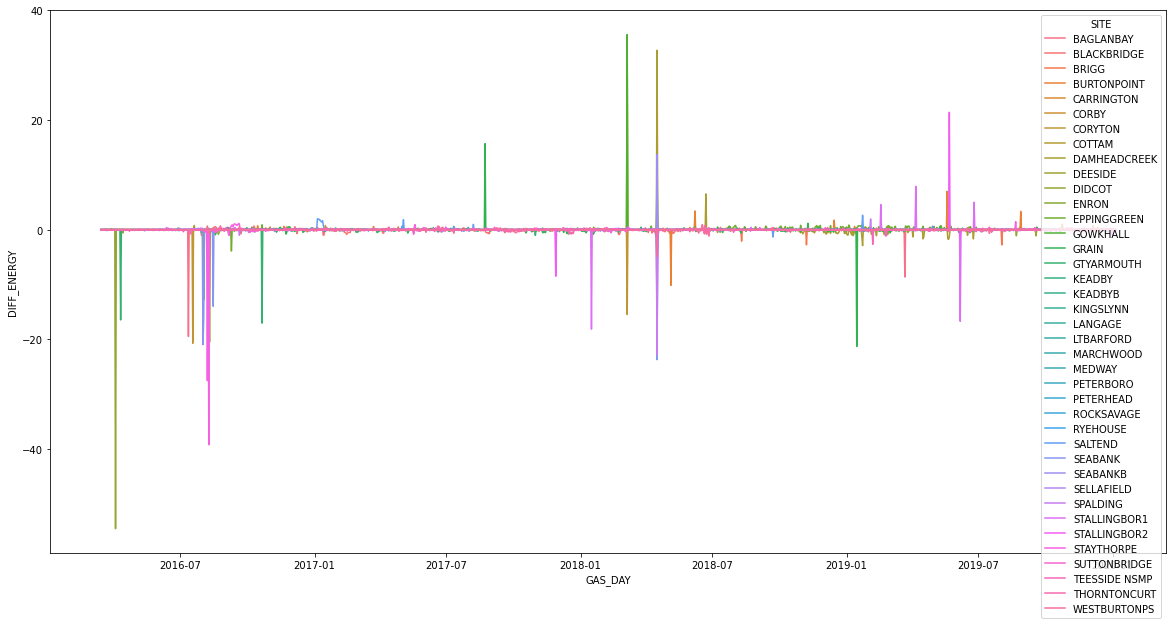

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.lineplot(
    data=compare, x="GAS_DAY", y="DIFF_ENERGY", hue="SITE", ax=ax,
)

# How does Temperature interact with CV?

In [64]:
compare

,GAS_DAY,SITE,VOLUME,CV,VOLUME_MULT_CV_GWH,ENERGY_GWH,DIFF_ENERGY
0,2016-03-14,BAGLANBAY,1.72800,39.21,18.820800,18.816562,-0.004238
1,2016-03-14,BLACKBRIDGE,8.12001,39.15,88.305109,88.322211,0.017102
2,2016-03-14,BRIGG,0.00000,39.74,0.000000,0.000000,0.000000
3,2016-03-14,BURTONPOINT,0.40800,39.78,4.508400,4.504462,-0.003938
4,2016-03-14,CORBY,0.00000,39.19,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
52333,2020-01-05,STAYTHORPE,1.32000,39.45,14.465000,14.455556,-0.009444
52334,2020-01-05,SUTTONBRIDGE,0.21300,39.33,2.327025,2.327778,0.000753
52335,2020-01-05,TEESSIDE NSMP,0.01398,39.57,0.153664,0.153610,-0.000054
52336,2020-01-05,THORNTONCURT,0.57290,39.32,6.257341,6.258889,0.001548


In [68]:
temperature = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\temperature.csv",
    keep_powerstations_only=False,
)
temperature = temperature.groupby("GAS_DAY")["VALUE"].mean().rename("TEMPERATURE")

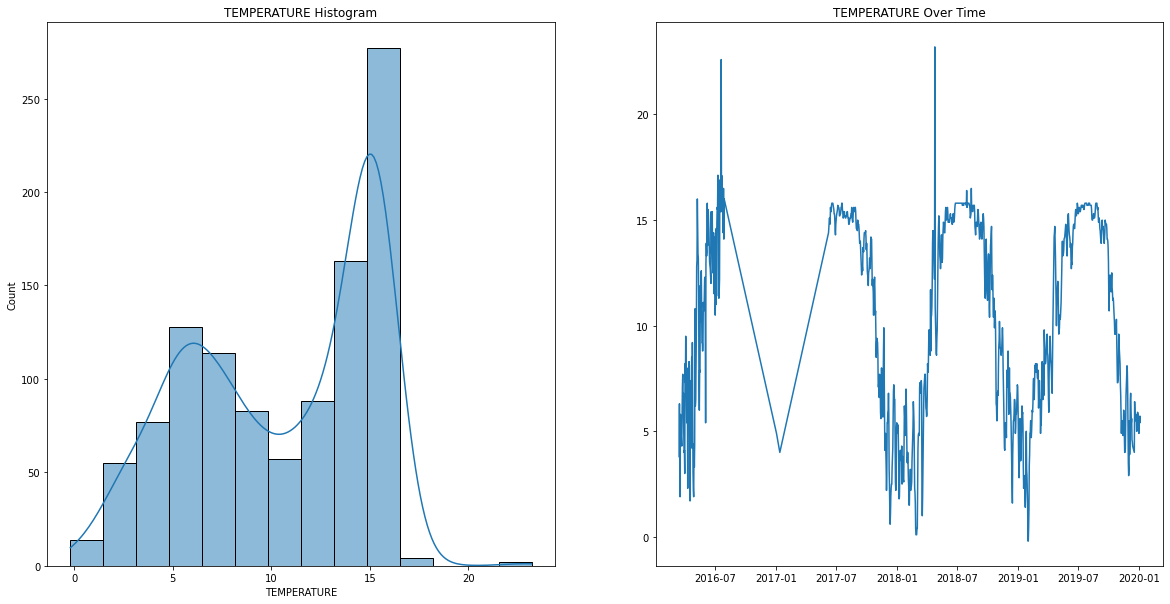

In [69]:
plot_series(temperature)

In [70]:
compare.merge(temperature, left_on="GAS_DAY", right_index=True)

,GAS_DAY,SITE,VOLUME,CV,VOLUME_MULT_CV_GWH,ENERGY_GWH,DIFF_ENERGY,TEMPERATURE
0,2016-03-14,BAGLANBAY,1.72800,39.21,18.820800,18.816562,-0.004238,3.8
1,2016-03-14,BLACKBRIDGE,8.12001,39.15,88.305109,88.322211,0.017102,3.8
2,2016-03-14,BRIGG,0.00000,39.74,0.000000,0.000000,0.000000,3.8
3,2016-03-14,BURTONPOINT,0.40800,39.78,4.508400,4.504462,-0.003938,3.8
4,2016-03-14,CORBY,0.00000,39.19,0.000000,0.000000,0.000000,3.8
...,...,...,...,...,...,...,...,...
52333,2020-01-05,STAYTHORPE,1.32000,39.45,14.465000,14.455556,-0.009444,5.7
52334,2020-01-05,SUTTONBRIDGE,0.21300,39.33,2.327025,2.327778,0.000753,5.7
52335,2020-01-05,TEESSIDE NSMP,0.01398,39.57,0.153664,0.153610,-0.000054,5.7
52336,2020-01-05,THORNTONCURT,0.57290,39.32,6.257341,6.258889,0.001548,5.7


# Does Temperature affect Efficiency?

In [ ]:
df = df.merge(temperature, how="left", left_on="GAS_DAY", right_on="GAS_DAY")
df = df[df.index.year > 2017]

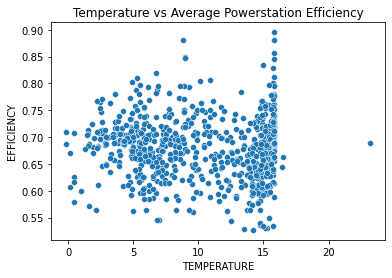

In [76]:
sns.scatterplot(data=df, x="TEMPERATURE", y="EFFICIENCY")
plt.title("Temperature vs Average Powerstation Efficiency")
plt.show()

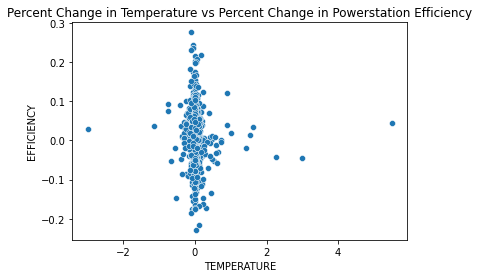

In [75]:
sns.scatterplot(data=df.pct_change(), x="TEMPERATURE", y="EFFICIENCY")
plt.title("Percent Change in Temperature vs Percent Change in Powerstation Efficiency")
plt.show()

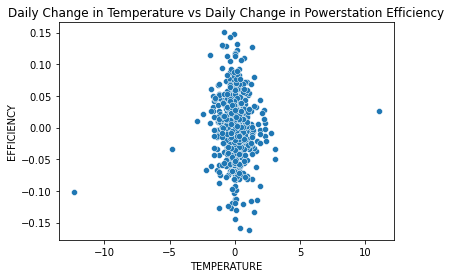

In [74]:
sns.scatterplot(data=df.diff(), x="TEMPERATURE", y="EFFICIENCY")
plt.title("Daily Change in Temperature vs Daily Change in Powerstation Efficiency")
plt.show()

# Archive

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.lineplot(
    data=gas_energy[gas_energy["POWERSTATION"]].dropna(),
    x="GAS_DAY",
    y="ENERGY",
    hue="SITE",
    ax=ax,
)

In [ ]:
gas_cv = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_CV.csv"
).rename({"VALUE": "CV"}, axis=1)
gas_cv = gas_cv[gas_cv["CV"] <= 43][37.5 <= gas_cv["CV"]]
cv_item_mapping = {}
for item in gas_cv["ITEM"].unique():
    try:
        site = item.split(",")[1].strip()
        cv_item_mapping[item] = site
    except:
        print(item)
gas_cv["SITE"] = gas_cv["ITEM"].map(cv_item_mapping)

In [ ]:
volume_item_mapping = {}
for item in volume["ITEM"].unique():
    try:
        site = item.split(",")[1].strip()
        volume_item_mapping[item] = site
    except:
        print(item)

volume["SITE"] = volume["ITEM"].map(volume_item_mapping)

In [ ]:
gas = pd.merge(volume, gas_cv, on=["SITE", "GAS_DAY"], suffixes=("_VOLUME", "_CV"))
gas["ENERGY_MJ"] = (gas["VOLUME"] / 1000000) * gas["CV"]

# M M3 * MJ/m3.

In [ ]:
gas

In [ ]:
daily_gas_volumes = (
    gas[gas["POWERSTATION_VOLUME"]].groupby("GAS_DAY")["VOLUME"].sum().tz_localize(None)
)

In [ ]:
daily_gas_cv = (
    gas[gas["POWERSTATION_CV"]].groupby("GAS_DAY")["CV"].mean().tz_localize(None)
)

In [ ]:
daily_gas_MJ = (
    gas[gas["POWERSTATION_CV"]].groupby("GAS_DAY")["ENERGY_MJ"].sum().tz_localize(None)
)

In [ ]:
daily_gas_GWH = daily_gas_volumes * 10.895

Similarly, seasonality is visible in the power station gas demand. There appear to be anomalies in the peak demeand at the start of every year, suggesting a possible accounting error and will be removed from further analysis.

In [ ]:
plot_series(daily_gas_MJ.rename("Gas (MJ)"))

In [ ]:
plot_series(daily_gas_GWH.rename("Gas (GWH)"))

In [ ]:
daily_gas_GWH = daily_gas_GWH[daily_gas_GWH < 1250]

## Does Calorific Value affect Efficiency?

Calorific value (CV) is a measure of heating power and is dependent upon the composition of the gas. The CV refers to the amount of energy released when a known volume of gas is completely combusted under specified conditions. The CV of gas, which is dry, gross and measured at standard conditions of temperature (15oC) and pressure (1013.25 millibars), is usually quoted in megajoules per cubic metre (MJ/m3). Gas passing through our pipeline system has a CV of 37.5 MJ/m3 to 43.0 MJ/m3.

[https://www.nationalgrid.com/uk/gas-transmission/data-and-operations/calorific-value-cv]

In [ ]:
gas_cv = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_CV.csv"
)
gas_cv = gas_cv[gas_cv["VALUE"] != 0]
daily_gas_cv = (
    gas_cv[gas_cv["POWERSTATION"]].groupby("GAS_DAY")["VALUE"].mean().tz_localize(None)
)
df = df.merge(daily_gas_cv.rename("CV"), how="left", left_index=True, right_index=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.lineplot(
    data=gas_cv[gas_cv["POWERSTATION"]][["GAS_DAY", "ITEM", "VALUE"]],
    x="GAS_DAY",
    y="VALUE",
    hue="ITEM",
    ax=ax,
    palette="Set2",
)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)

In [ ]:
plot_series(df["CV"].rename("Calorific Value"))

In [ ]:
plt.scatter(df["CV"], df["EFFICIENCY"])
plt.title("CV vs Powerstation Efficiency")
plt.show()